######  1. 初始状态

            host_name        hash      diff
0     d-05.winudf.com    29527716  29527716
1     d-05.winudf.com    29646980    119264
2     d-05.winudf.com    29998276    351296
3     d-05.winudf.com    30364388    366112
4     d-05.winudf.com    31012388    648000
5     d-01.winudf.com    46291963  15279575
6     d-01.winudf.com    46446043    154080
7     d-01.winudf.com    46754203    308160
8     d-01.winudf.com    47155131    400928
9     d-01.winudf.com    48172379   1017248
10    d-03.winudf.com    55142690   6970311
11    d-04.winudf.com    59463494   4320804
12    d-04.winudf.com    59619686    156192
13    d-04.winudf.com    65145350   5525664
14    d-04.winudf.com    65332262    186912
15    d-04.winudf.com    65615974    283712
16    d-02.winudf.com    65863521    247547
17    d-04.winudf.com    66049606    186085
18    d-02.winudf.com    66169281    119675
19    d-04.winudf.com    66224358     55077
20    d-02.winudf.com    66537441    313083
21    d-02.winudf.com    6675548

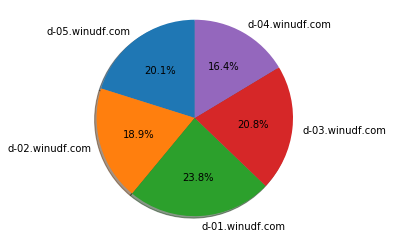

In [2]:
%run fsrouter.py

##### 1.1 100次请求后，动态调整

In [ ]:
# 1. avg_balance = 100 / 5 = 20
# 2. total_load = 100 
#     预期: d01, d02, d03, d04, d05 均20 
#     实际值: d01=23.8 d02=18.9 d03=20.8, d04=16.4, d05=20.1
# 3. 处理流程：
#    需要一个衡量函数，判断当前负载异常率大于容忍范围。5% (最大和最小负载之间)
# 3.0 get_host(fid): 返回d0x.  
#     3.1 get_load_pie() --> 返回排序由大到小的负载率. { "d01": 23.8%, "d02":18.9%, "d03":20.8%, "d04":16.4%, "d05":20.1%}
#     3.2 check_over_load(max_load, min_load) ---> 返回True/False. 
#     3.3 if check_over_load(max_load, min_load):
#             host = load_balance() # 通过一直负载调整，获取host
#         else:
#             host = 一致性host
#     3.4  返回host
# 4.0 load_balance():   
#     减小master的百分比，达到avg_balance?
#     4.1 负载和值域成正比？
#     4.2 如何调整？把load_max_host 的replicate 减少，从而减小了该 host的百分比. 
#                 load_max_host-r减小, d01-r41-50 被移除. (hash(d01-r41-50))
#                 load_min_host-r增加, d04-r51-60 新增加. (hash(d04-r51-60))
#                 把 hash(d01-r41-50) => 原来的d01->d04, 整个值域的hash值均没有发生改变，d01部分数据转移到d04
# 
#     4.3 如r50->r40, 前r0-40不受影响，仍然在该host, 原来r41-50 直接的hash值，将有可能转移到其他的主机。
#     4.4 
# 
#  1.if check_voer_load():
#       load_balance()
#  2. host = get_host(fid)
# 
# 新思路： 通过设置d01: 20%, d02: 30% d03: 50%, 然后在运行的过程中，调整hash 的分布，实现预期的分布比.
# 
# 需求重新定义：
#     1. 需要的是控制每一台机器的带宽负载.
#     2. 同时新加入机器／移除机器时，影响是局部的.
# 
# 重新设计目标:
#     1. 尽可能保证hash 的均匀性.   (带宽的负载均衡，实现等比列增长)
#     2. 最大限度的利用hash 的一致性. （保证文件系统的缓存命名率）
# 重新设计流程:
# 
#
#

In [6]:
def md5_encode(str):
    import hashlib
    m = hashlib.md5()
    m.update(str)
    return m.hexdigest()

In [8]:
md5_encode("tplinux.cn".encode("utf-8"))

'87312b23c915485093573b1f48510174'

In [9]:
# v1.0 版本测试， 把d01-r41-50 --> 对应的hash修改为d05


          host_name        hash       diff
0   d-03.winudf.com    55142690   55142690
1   d-02.winudf.com    65863521   10720831
2   d-05.winudf.com    73894305    8030784
3   d-04.winudf.com    79831010    5936705
4   d-01.winudf.com   123843294   44012284
5   d-03.winudf.com   167979899   44136605
6   d-02.winudf.com   178699576   10719677
7   d-02.winudf.com   369508983  190809407
8   d-03.winudf.com   379835444   10326461
9   d-04.winudf.com   409133229   29297785
10  d-05.winudf.com   415725294    6592065
11  d-01.winudf.com   465653137   49927843
12  d-02.winudf.com   594414026  128760889
13  d-03.winudf.com   600547209    6133183
14  d-04.winudf.com   755673872  155126663
15  d-05.winudf.com   766459219   10785347
16  d-01.winudf.com   782829100   16369881
17  d-05.winudf.com   823116316   40287216
18  d-04.winudf.com   833246303   10129987
19  d-01.winudf.com   839514467    6268164
20  d-03.winudf.com   908141215   68626748
21  d-02.winudf.com   914666716    6525501
22  d-03.wi

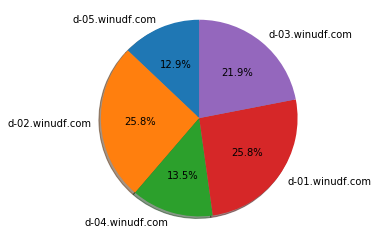

In [10]:
%run fsrouter.py

          host_name        hash       diff
0   d-03.winudf.com    55142690   55142690
1   d-04.winudf.com    65863521   10720831
2   d-05.winudf.com    73894305    8030784
3   d-04.winudf.com    79831010    5936705
4   d-01.winudf.com   123843294   44012284
5   d-03.winudf.com   167979899   44136605
6   d-02.winudf.com   178699576   10719677
7   d-02.winudf.com   369508983  190809407
8   d-03.winudf.com   379835444   10326461
9   d-04.winudf.com   409133229   29297785
10  d-05.winudf.com   415725294    6592065
11  d-01.winudf.com   465653137   49927843
12  d-02.winudf.com   594414026  128760889
13  d-03.winudf.com   600547209    6133183
14  d-04.winudf.com   755673872  155126663
15  d-05.winudf.com   766459219   10785347
16  d-01.winudf.com   782829100   16369881
17  d-05.winudf.com   823116316   40287216
18  d-04.winudf.com   833246303   10129987
19  d-01.winudf.com   839514467    6268164
20  d-03.winudf.com   908141215   68626748
21  d-02.winudf.com   914666716    6525501
22  d-03.wi

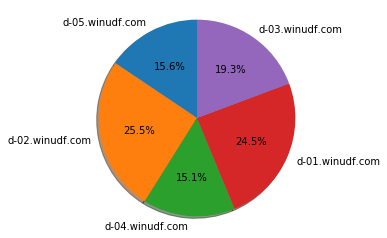

In [17]:
#第一次均衡后, d01->d05 
%run fsrouter.py

In [ ]:
# d01->d05